# Data Cleaning Revision

From our Data Cleaning training session, I learned the importance of guarding against Cartesian joins. A Cartesian product consists of every possible combination of rows from the tables. This result set is usually extremely large and unwieldy, killing application performance. Additionally, I understood that effective data cleaning requires performing Exploratory Data Analysis (EDA), and that this process is cyclical. In this notebook, I aim to deepen my understanding of data balance and imbalance by visualizing it using box plots. I also plan to use the [MissingNo library](https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/) to visualize missing values (NaNs).

### Imports

In [68]:
# Libraries
import pandas as pd
import os
import sys
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


# Functions
src_path = os.path.abspath('../src/')
sys.path.append(src_path)

from data_cleaning import standardize_col_names, null_counts

In [2]:
input_loc = '../data/raw/'

# Read in the data
sample_submission = pd.read_csv(os.path.join(input_loc, 'sample_submission.csv'))
train_identity = pd.read_csv(os.path.join(input_loc, 'train_identity.csv'))
train_transaction = pd.read_csv(os.path.join(input_loc, 'train_transaction.csv'))
test_identity = pd.read_csv(os.path.join(input_loc, 'test_identity.csv'))
test_transaction = pd.read_csv(os.path.join(input_loc, 'test_transaction.csv'))

/var/folders/sr/c4hqwd5d201c391w690mwpxc0000gn/T/ipykernel_10327/3699146215.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  train_identity = pd.read_csv(os.path.join(input_loc, 'train_identity.csv'))
/var/folders/sr/c4hqwd5d201c391w690mwpxc0000gn/T/ipykernel_10327/3699146215.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  test_identity = pd.read_csv(os.path.join(input_loc, 'test_identity.csv'))


In [3]:
# What is the data's shape?
print(sample_submission.shape)
print(train_identity.shape)
print(train_transaction.shape)
print(test_identity.shape)
print(test_transaction.shape)

(506691, 2)
(5769320, 3)
(590540, 403)
(5676280, 3)
(506691, 402)


Observations:
- `sample_submission` has 506,691 rows and 2 columns. This is the template for our predictions.
- `test_identity` and `train_identity` are long-format datasets with approximately 5.7 million rows and 3 columns each.
- `test_transaction` and `train_transaction` are wide-format datasets with around 500,000 rows and over 400 columns each. The training set includes the target variable `isFraud`.

<b>What's in the data?</b>

In [4]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [5]:
train_identity.head()

,TransactionID,variable,value
0,2987004,id_01,0.0
1,2987008,id_01,-5.0
2,2987010,id_01,-5.0
3,2987011,id_01,-5.0
4,2987016,id_01,0.0


Observation: Identity information is stored in a long format, with each `TransactionID` having multiple `variable` and `value` pairs.

In [6]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,V340
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [7]:
test_identity.head()

,TransactionID,variable,value
0,3663586,id_01,-45.0
1,3663588,id_01,0.0
2,3663597,id_01,-5.0
3,3663601,id_01,-45.0
4,3663602,id_01,-95.0


Observation: Follows the same long format as `train_identity`.

In [8]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,V340
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Summary
- The data includes both transaction and identity information for training and testing.
- The `train_transaction` and `test_transaction` datasets are wide, containing many features.
- The `train_identity` and `test_identity` datasets are long, containing key-value pairs for additional identity attributes.
- The `sample_submission` dataset provides a template for predictions, indicating that `isFraud` in this context might represent a probability.

<b>Reshape the Identity Data</b>

In [9]:
# Reshape the train_identity data from long to wide format
train_identity_wide = train_identity.pivot(index='TransactionID', columns='variable', values='value').reset_index()

# Reshape the test_identity data from long to wide format
test_identity_wide = test_identity.pivot(index='TransactionID', columns='variable', values='value').reset_index()

<b>Merge the Reshaped Identity Data with Transaction Data on `TransactionID`</b>

In [10]:
# Merge train_identity_wide with train_transaction
train_data = pd.merge(train_transaction, train_identity_wide, on='TransactionID', how='left')

# Merge test_identity_wide with test_transaction
test_data = pd.merge(test_transaction, test_identity_wide, on='TransactionID', how='left')

<b>Verify the Merges</b>

In [11]:
# Verify the shapes of the merged data
print(train_data.shape)
print(test_data.shape)

(590540, 443)
(506691, 442)


<b>Getting to know the data and it's missing values</b>

In [12]:
# List all columns in train_data
train_columns = train_data.columns

# Print each column name
for col in train_columns:
    print(col)

TransactionID
isFraud
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
v5
V6
V7
V8
V9
V10
V11
v12
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
v42
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
v139
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
v157
V158
V159
V160
V161
V162
V16

To effectively use the `missingno` library for visualizing missing values in my dataset, I will group columns logically to better understand the distribution of missing data. 

Grouping columns by their logical categories:
1. Transaction Information
2. Card Information 
3. Address Information
4. Email Information
5. C Columns
6. D Columns
7. M Columns
8. V Columns
9. Identity Information

<b>Group 1: Transaction Information</b> 
- Columns: `TransactionID`, `isFraud`, `TransactionDT`, `TransactionAmt`, `ProductCD`
- Description:
    - TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
    - TransactionAMT: transaction payment amount in USD
    - ProductCD: product code, the product for each transaction
- Hints:
    - TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.
    - Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?
    - Product isn't necessary to be a real 'product' (such as an item to be added to the shopping cart). It could be any kind of service.

`isFraud`

In [13]:
# Count occurrences of each unique value in the isFraud column
fraud_counts = train_data['isFraud'].value_counts()

# Print the counts
print(fraud_counts)

isFraud
0    569877
1     20663
Name: count, dtype: int64


In [14]:
# Check for missing values in the isFraud column
missing_values = train_data['isFraud'].isnull().sum()

# Print the count of missing values
print("Number of missing values in isFraud column:", missing_values)

Number of missing values in isFraud column: 0


`TransactionDT`

In [15]:
transactiondt_values = train_data['TransactionDT'].value_counts()
print(transactiondt_values)

TransactionDT
9474817     8
11576951    5
4397066     5
7236588     5
1544629     4
           ..
4629634     1
4629631     1
4629557     1
4629466     1
15811131    1
Name: count, Length: 573349, dtype: int64


In [16]:
# Check for missing values in the TransactionDT column
TransactionDT_missing_values = train_data['TransactionDT'].isnull().sum()

# Print the count of missing values
print("Number of missing values in TransactionDT column:", TransactionDT_missing_values)

Number of missing values in TransactionDT column: 0


`TransactionAmt`

In [17]:
TransactionAmt_values = train_data['TransactionAmt'].value_counts()
print(TransactionAmt_values)

TransactionAmt
59.000     30582
117.000    28933
107.950    23954
57.950     23600
100.000    20362
           ...  
215.550        1
298.600        1
203.270        1
105.614        1
400.780        1
Name: count, Length: 20902, dtype: int64


In [56]:
# Check for missing values in the TransactionAmt column
TransactionAmt_missing_values = train_data['TransactionAmt'].isnull().sum()

# Print the count of missing values
print("Number of missing values in TransactionAmt column:", TransactionAmt_missing_values)

Number of missing values in TransactionAmt column: 0


`ProductCD`

In [19]:
ProductCD_values = train_data['ProductCD'].value_counts()
print(ProductCD_values)

ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: count, dtype: int64


In [20]:
# Check for missing values in the TransactionDT column
ProductCD_missing_values = train_data['ProductCD'].isnull().sum()

# Print the count of missing values
print("Number of missing values in ProductCD column:", ProductCD_missing_values)

Number of missing values in ProductCD column: 0


Group 1 Summary:
- No missing values
- All columns are int64
- Need to figure out what product codes: W, C, R, H, S mean?

<b>Group 2: Card Information</b> 
- Columns: `card1`, `card2`, `card3`, `card4`, `card5`, `card6`
- Description: payment card information, such as card type, card category, issue bank, country, etc.

`card1`

In [21]:
# Count occurrences of each unique value in the card1 column
card1_counts = train_data['card1'].value_counts()

# Print the counts
print(card1_counts)

card1
7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
17084        1
14620        1
11440        1
13231        1
18038        1
Name: count, Length: 13553, dtype: int64


In [22]:
# Check for missing values in the card1 column
card1_missing_values = train_data['card1'].isnull().sum()

# Print the count of missing values
print("Number of missing values in card1 column:", card1_missing_values)

Number of missing values in card1 column: 0


`card2`

In [23]:
# Count occurrences of each unique value in the card2 column
card2_counts = train_data['card2'].value_counts()

# Print the counts
print(card2_counts)

card2
321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803
         ...  
388.0       39
153.0       38
557.0       37
473.0       18
582.0       14
Name: count, Length: 500, dtype: int64


In [24]:
# Check for missing values in the card2 column
card2_missing_values = train_data['card2'].isnull().sum()

# Print the count of missing values
print("Number of missing values in card2 column:", card2_missing_values)

Number of missing values in card2 column: 8933


`card3`

In [25]:
# Count occurrences of each unique value in the card3 column
card3_counts = train_data['card3'].value_counts()

# Print the counts
print(card3_counts)

card3
150.0    521287
185.0     56346
106.0      1571
144.0      1252
146.0      1252
          ...  
224.0         1
199.0         1
221.0         1
209.0         1
173.0         1
Name: count, Length: 114, dtype: int64


In [26]:
# Check for missing values in the card3 column
card3_missing_values = train_data['card3'].isnull().sum()

# Print the count of missing values
print("Number of missing values in card3 column:", card3_missing_values)

Number of missing values in card3 column: 1565


`card4`

In [27]:
# Count occurrences of each unique value in the card4 column
card4_counts = train_data['card4'].value_counts()

# Print the counts
print(card4_counts)

card4
visa                384767
mastercard          189217
american express      8328
discover              6651
Name: count, dtype: int64


In [28]:
# Check for missing values in the card4 column
card4_missing_values = train_data['card4'].isnull().sum()

# Print the count of missing values
print("Number of missing values in card4 column:", card4_missing_values)

Number of missing values in card4 column: 1577


`card5`

In [29]:
# Count occurrences of each unique value in the card5 column
card5_counts = train_data['card5'].value_counts()

# Print the counts
print(card5_counts)

card5
226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941
          ...  
221.0         1
167.0         1
115.0         1
165.0         1
234.0         1
Name: count, Length: 119, dtype: int64


In [30]:
# Check for missing values in the card5 column
card5_missing_values = train_data['card5'].isnull().sum()

# Print the count of missing values
print("Number of missing values in card5 column:", card5_missing_values)

Number of missing values in card5 column: 4259


`card6`

In [31]:
# Count occurrences of each unique value in the card6 column
card6_counts = train_data['card6'].value_counts()

# Print the counts
print(card6_counts)

card6
debit              439938
credit             148986
debit or credit        30
charge card            15
Name: count, dtype: int64


In [32]:
# Check for missing values in the card6 column
card6_missing_values = train_data['card6'].isnull().sum()

# Print the count of missing values
print("Number of missing values in card6 column:", card6_missing_values)

Number of missing values in card6 column: 1571


Group 2 Summary:
- All columns are int64
- `card4` has unique values of `visa`, `mastercard`, `american express`, and `disover`
- `card6` has unique values of `debit`, `credit`, `debit or credit`, `charge card`
- There are no missing values in `card1`
- There are missing values in columns: `card2` = 8933, `card3` = 1565, `card4` = 1577, `card5` = 4259, `card6` = 1571

<b>Handle Missing Values for Group 2:</b>

Mode Imputation for Categorical Columns (`card4`, `card6`):
- Mode Imputation: Replace missing values with the mode (most frequent value).
    - Pros: Effective for categorical data.
    - Cons: Can introduce bias if the mode is not representative.

In [57]:
train_data['card4'].fillna(train_data['card4'].mode()[0], inplace=True)
train_data['card6'].fillna(train_data['card6'].mode()[0], inplace=True)

KNN Imputation for Numerical Columns (`card2`, `card3`, `card5`):
- K-Nearest Neighbors (KNN) Imputation: Use the KNN algorithm to impute missing values based on similar rows.
    - Pros: More sophisticated; can capture complex relationships in the data.
    - Cons: Computationally expensive; may introduce bias if the data has clusters.
python


In [60]:
imputer = KNNImputer(n_neighbors=5)
train_data[['card2', 'card3', 'card5']] = imputer.fit_transform(train_data[['card2', 'card3', 'card5']])

Comined with Missing Indicators in case Missingness is Informative:

In [61]:
train_data['card2_missing'] = train_data['card2'].isnull().astype(int)
train_data['card3_missing'] = train_data['card3'].isnull().astype(int)
train_data['card5_missing'] = train_data['card5'].isnull().astype(int)

<b>Group 3: Address Information</b>
- Columns: `addr1`, `addr2`, `dist1`, `dist2`
- Description:
   - address: both addresses are for the purchaser
   - addr1: as billing region
   - addr2: as billing country
   - dist: distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.

`addr1`

In [33]:
# Count occurrences of each unique value in the addr1 column
addr1_counts = train_data['addr1'].value_counts()

# Print the counts
print(addr1_counts)

addr1
299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
         ...  
386.0        1
101.0        1
353.0        1
516.0        1
245.0        1
Name: count, Length: 332, dtype: int64


In [34]:
# Check for missing values in the addr1 column
addr1_missing_values = train_data['addr1'].isnull().sum()

# Print the count of missing values
print("Number of missing values in addr1 column:", addr1_missing_values)

Number of missing values in addr1 column: 65706


`addr2`

In [35]:
# Count occurrences of each unique value in the addr2 column
addr2_counts = train_data['addr2'].value_counts()

# Print the counts
print(addr2_counts)

addr2
87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
         ...  
49.0         1
14.0         1
25.0         1
22.0         1
93.0         1
Name: count, Length: 74, dtype: int64


In [36]:
# Check for missing values in the addr2 column
addr2_missing_values = train_data['addr2'].isnull().sum()

# Print the count of missing values
print("Number of missing values in addr2 column:", addr2_missing_values)

Number of missing values in addr2 column: 65706


`dist1`

In [37]:
# Count occurrences of each unique value in the dist1 column
dist1_counts = train_data['dist1'].value_counts()

# Print the counts
print(dist1_counts)

dist1
0.0       19824
1.0       18330
2.0       17028
4.0       13067
3.0       12808
          ...  
4171.0        1
1670.0        1
2003.0        1
1973.0        1
1907.0        1
Name: count, Length: 2651, dtype: int64


In [38]:
# Check for missing values in the dist1 column
dist1_missing_values = train_data['dist1'].isnull().sum()

# Print the count of missing values
print("Number of missing values in dist1 column:", dist1_missing_values)

Number of missing values in dist1 column: 352271


`dist2`

In [39]:
# Count occurrences of each unique value in the dist2 column
dist2_counts = train_data['dist2'].value_counts()

# Print the counts
print(dist2_counts)

dist2
7.0       5687
0.0       3519
1.0       1374
9.0        742
4.0        659
          ... 
2015.0       1
2124.0       1
1347.0       1
1776.0       1
2296.0       1
Name: count, Length: 1751, dtype: int64


In [40]:
# Check for missing values in the dist1 column
dist2_missing_values = train_data['dist2'].isnull().sum()

# Print the count of missing values
print("Number of missing values in dist2 column:", dist2_missing_values)

Number of missing values in dist2 column: 552913


Summary of Group 3:
- All columns are integers
- `add1` and `add2` have the same amount of missing values of 65,706.
- `dist1` has 352,271 missing values
- `dist2` has 552,913 missing values

Handling missing values for `add1` and `add2`

These columns represent categorical data. Assigning a placeholder value such as -1 for missing entries can be useful. This clearly indicates that the value is missing without introducing any bias.

In [63]:
# Assign a placeholder value for missing values in addr1 and addr2
train_data['addr1'].fillna(-1, inplace=True)
train_data['addr2'].fillna(-1, inplace=True)

Handling missing values for `dist1` and `dist2`

In [64]:
# Assign a placeholder value for missing values in dist1 and dist2
train_data['dist1'].fillna(-1, inplace=True)
train_data['dist2'].fillna(-1, inplace=True)

In [65]:
# Print the updated columns to verify the changes
print(train_data[['addr1', 'addr2', 'dist1', 'dist2']].head())

   addr1  addr2  dist1  dist2
0  315.0   87.0   19.0   -1.0
1  325.0   87.0   -1.0   -1.0
2  330.0   87.0  287.0   -1.0
3  476.0   87.0   -1.0   -1.0
4  420.0   87.0   -1.0   -1.0


For numerical columns, assigning a specific value that indicates missing data (e.g., -1) can help. This approach is particularly useful if the data could be crucial and we want to explicitly mark it as missing.

<b>Group 4: Email Information</b>
- Columns: `P_emaildomain`, `R_emaildomain`
- Description: purchaser and recipient email domain
- Hint:
   - Certain transactions don't need recipient, so R_emaildomain is null.

`P_emaildomain`

In [41]:
# Count occurrences of each unique value in the P_emaildomain column
P_emaildomain_counts = train_data['P_emaildomain'].value_counts()

# Print the counts
print(P_emaildomain_counts)

P_emaildomain
gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com   

In [42]:
# Check for missing values in the P_emaildomain column
P_emaildomain_missing_values = train_data['P_emaildomain'].isnull().sum()

# Print the count of missing values
print("Number of missing values in P_emaildomain column:", P_emaildomain_missing_values)

Number of missing values in P_emaildomain column: 94456


`R_emaildomain`

In [43]:
# Count occurrences of each unique value in the R_emaildomain column
R_emaildomain_counts = train_data['R_emaildomain'].value_counts()

# Print the counts
print(R_emaildomain_counts)

R_emaildomain
gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
ymail.com             207
prodigy.net.mx        207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               5

In [44]:
# Check for missing values in the R_emaildomain column
R_emaildomain_missing_values = train_data['R_emaildomain'].isnull().sum()

# Print the count of missing values
print("Number of missing values in R_emaildomain column:", R_emaildomain_missing_values)

Number of missing values in R_emaildomain column: 453249


Handeling missing values for Group 4:
- Given the nature of the `P_emaildomain` and `R_emaildomain` columns, here’s how I will handle them:
    - `P_emaildomain` (Purchaser email domain): Missing values in this column can be replaced with a placeholder like "unknown", as the email domain is crucial information and we shouldn't make any assumptions about it.
    - `R_emaildomain` (Recipient email domain): Since not all transactions require a recipient, missing values in this column can be replaced with a specific placeholder like "no_recipient" to indicate that no recipient email was provided.

In [66]:
# Replace missing values in P_emaildomain with 'unknown'
train_data['P_emaildomain'].fillna('unknown', inplace=True)

# Replace missing values in R_emaildomain with 'no_recipient'
train_data['R_emaildomain'].fillna('no_recipient', inplace=True)

# Print the count of missing values again to verify they have been filled
print("Number of missing values after filling:")
print("P_emaildomain:", train_data['P_emaildomain'].isnull().sum())
print("R_emaildomain:", train_data['R_emaildomain'].isnull().sum())

# Print the first few rows of the updated columns to verify the changes
print(train_data[['P_emaildomain', 'R_emaildomain']].head())

Number of missing values after filling:
P_emaildomain: 0
R_emaildomain: 0
  P_emaildomain R_emaildomain
0       unknown  no_recipient
1     gmail.com  no_recipient
2   outlook.com  no_recipient
3     yahoo.com  no_recipient
4     gmail.com  no_recipient


<b>Group 5: C Columns</b>
- Columns: `C1` to `C14`
- Description: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- Hint:
    - Counting of various entities like devices, IP addresses, billing addresses, and more. These counts apply to both purchasers and recipients, effectively doubling the number of variables.

In [45]:
# Check data types and missing values of columns C1 to C14
C1_to_C14_data = train_data.loc[:, 'C1':'C14']
print("Data types of columns C1 to C14:")
print(C1_to_C14_data.dtypes)

print("\nMissing values in columns C1 to C14:")
print(C1_to_C14_data.isnull().sum())

Data types of columns C1 to C14:
C1     float64
C2     float64
C3     float64
C4     float64
C5     float64
C6     float64
C7     float64
C8     float64
C9     float64
C10    float64
C11    float64
C12    float64
C13    float64
C14    float64
dtype: object

Missing values in columns C1 to C14:
C1     0
C2     0
C3     0
C4     0
C5     0
C6     0
C7     0
C8     0
C9     0
C10    0
C11    0
C12    0
C13    0
C14    0
dtype: int64


<b>Group 6: D Columns</b>
- Columns: `D1` to `D15`
- Description: timedelta, such as days between previous transaction, etc.

In [46]:
# Check data types and missing values of columns D1 to D15
D1_to_D15_data = train_data.loc[:, 'D1':'D15']
print("Data types of columns D1 to D15:")
print(D1_to_D15_data.dtypes)

print("\nMissing values in columns D1 to D15:")
print(D1_to_D15_data.isnull().sum())

Data types of columns D1 to D15:
D1     float64
D2     float64
D3     float64
D4     float64
D5     float64
D6     float64
D7     float64
D8     float64
D9     float64
D10    float64
D11    float64
D12    float64
D13    float64
D14    float64
D15    float64
dtype: object

Missing values in columns D1 to D15:
D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
dtype: int64


Steps to Address Missing Values in Group 6: D Columns
- Understanding the nature of missing values: Analyzing the distribution and pattern of missing values across `D1` to `D15`. Missing values range from as low as 1,269 in `D1` to as high as 551,623 in `D7`.

Since these values could indeed signify no previous transaction(at least within the data's timeframe) rather than being missing, imputing with zero might be more appropriate. This approach acknowledges that a missing value in these columns could simply mean that there was no previous transaction to calculate a timedelta from.

In [72]:
# Columns to impute
d_columns_to_impute = ['D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14']

# Impute missing values with zero for columns D2 to D9, D11 to D14
train_data[d_columns_to_impute] = train_data[d_columns_to_impute].fillna(0)

# Check if there are still missing values after imputation
print("Missing values after imputation:")
print(train_data[d_columns_to_impute].isnull().sum())

Missing values after imputation:
D2     0
D3     0
D4     0
D5     0
D6     0
D7     0
D8     0
D9     0
D11    0
D12    0
D13    0
D14    0
dtype: int64


<b>Group 7: M Columns</b>
- Columns: `M1` to `M9`
- Description: match, such as names on card and address, etc.
- Hint: Mx is attribute of matching check, e.g. is phone areacode matched with billing zipcode, purchaser and recipient first/or last name match, etc.

In [47]:
# Check data types and missing values of columns D1 to D15
M1_to_M9_data = train_data.loc[:, 'M1':'M9']
print("Data types of columns M1 to M9:")
print(M1_to_M9_data.dtypes)

print("\nMissing values in columns D1 to D15:")
print(M1_to_M9_data.isnull().sum())

Data types of columns M1 to M9:
M1    object
M2    object
M3    object
M4    object
M5    object
M6    object
M7    object
M8    object
M9    object
dtype: object

Missing values in columns D1 to D15:
M1    271100
M2    271100
M3    271100
M4    281444
M5    350482
M6    169360
M7    346265
M8    346252
M9    346252
dtype: int64


Handling the missing values for Group 7:
- All columns (`M1` to `M9`) have a significant number of missing values ranging from 169,360 in `M6` to 350,482 in `M5`.
These columns are of type object, suggesting they contain categorical data related to matching attributes.
- For categorical columns like `M1` to `M9`, a common approach is to impute missing values with a new category label that indicates missingness. This preserves the information that these values were initially missing and prevents biasing the model towards existing categories.
- By using scikit-learn's SimpleImputer with strategy='constant' to replace missing values with a specified constant, which will be a new category label (e.g., `missing`).

In [71]:
# Columns to impute
m_columns_to_impute = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

# Impute missing values with a new category "missing"
imputer = SimpleImputer(strategy='constant', fill_value='missing')
train_data[m_columns_to_impute] = imputer.fit_transform(train_data[m_columns_to_impute])

# Check if there are still missing values after imputation
print("Missing values after imputation:")
print(train_data[m_columns_to_impute].isnull().sum())

Missing values after imputation:
M1    0
M2    0
M3    0
M4    0
M5    0
M6    0
M7    0
M8    0
M9    0
dtype: int64


<b>Group 8: V Columns</b>
- Columns: `V1` to `V340`
- Description: Vesta engineered rich features, including ranking, counting, and other entity relations.
- Hint:
    - These columns might represent how frequently a payment card associated with an IP address or email appears within a 24-hour timeframe. All Vesta features are numerical, derived from counts of orders within a clustering, time-period, or condition, giving them a finite value and ordering. It's not recommended to treat any of them as categorical. However, if any of them happen to result in binary values by chance, it might be worth exploring further."

In [48]:
# Check data types and missing values of columns V1 to V340
V1_to_V340_data = train_data.loc[:, 'V1':'V340']
print("Data types of columns V1 to V340:")
print(V1_to_V340_data.dtypes)

print("\nMissing values in columns V1 to V340:")
print(V1_to_V340_data.isnull().sum())

Data types of columns V1 to V340:
V1      float64
V2      float64
V3      float64
V4      float64
V5      float64
         ...   
V336    float64
V337    float64
V338    float64
V339    float64
V340    float64
Length: 348, dtype: object

Missing values in columns V1 to V340:
V1      279287
V2      279287
V3      279287
V4      279287
V5      279287
         ...  
V336    508189
V337    508189
V338    508189
V339    508189
V340    590540
Length: 348, dtype: int64


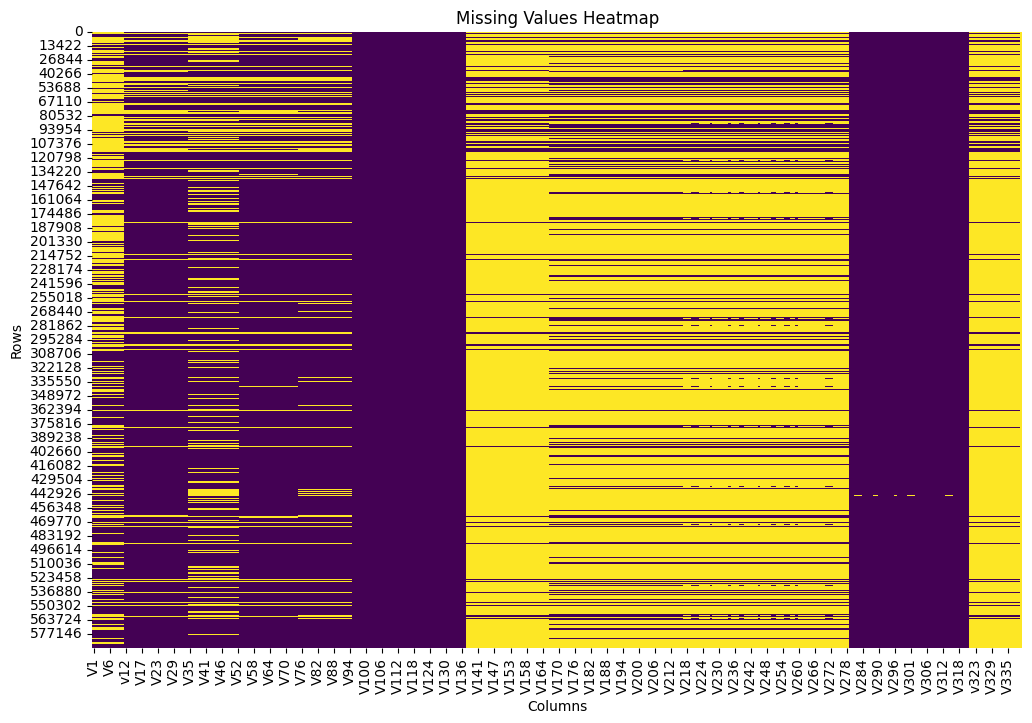

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize missing data patterns using a heatmap
V1_to_V340_data = train_data.loc[:, 'V1':'V340']

# Visualize missing data patterns
plt.figure(figsize=(12, 8))
sns.heatmap(V1_to_V340_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [50]:
# Summary of missing values
missing_summary = V1_to_V340_data.isnull().sum().sort_values(ascending=False)
print("Missing values summary:")
print(missing_summary)

Missing values summary:
V340    590540
V163    508595
V161    508595
V158    508595
v157    508595
         ...  
V309        12
V310        12
V311        12
V312        12
V299        12
Length: 348, dtype: int64


The missing values in these columns might represent two things.
1. <b>Absence of Events:</b> If a particular count is missing, it could imply that there were no events (e.g., no transactions associated with a particular IP address or email) during the specified timeframe.
2. <b>Data Gaps:</b> Missing values might also arise from incomplete data collection or errors in the dataset.

To handle these missing values appropriately, I will interpret the missing values as zero. 
- Since the features are counts, a missing value can reasonably be interpreted as zero, indicating no events were recorded for that specific feature and timeframe.
- It is best practice to avoid imputation with mean or median. Using mean or median imputation might distort the data because it implies that there were some events, rather than none.

In [73]:
# Replace missing values with zero for V1 to V340 columns
v_columns_to_impute = V1_to_V340_data.columns
train_data[v_columns_to_impute] = train_data[v_columns_to_impute].fillna(0)

# Check if there are still missing values after imputation
print("Missing values after replacing with zero:")
print(train_data[v_columns_to_impute].isnull().sum())

Missing values after replacing with zero:
V1      0
V2      0
V3      0
V4      0
V5      0
       ..
V336    0
V337    0
V338    0
V339    0
V340    0
Length: 348, dtype: int64


<b>Group 9: Identity Information</b>
- Columns: `id_01` to `id_38`, `DeviceInfo`, `DeviceType`
- Description: This group encompasses identity information, including network connection details (such as IP, ISP, Proxy) and digital signatures (UA/browser/os/version, etc) associated with transactions. These data points are collected by Vesta’s fraud protection system and its digital security partners.
- Hint: Understanding the identity information associated with transactions can provide insights into patterns of fraudulent activity, especially when analyzing network connections and device characteristics.

In [51]:
# Check data types of columns id_01 to id_38
print(train_data.loc[:, 'id_01':'id_38'].dtypes)

id_01    object
id_02    object
id_03    object
id_04    object
id_05    object
id_06    object
id_07    object
id_08    object
id_09    object
id_10    object
id_11    object
id_12    object
id_13    object
id_14    object
id_15    object
id_16    object
id_17    object
id_18    object
id_19    object
id_20    object
id_21    object
id_22    object
id_23    object
id_24    object
id_25    object
id_26    object
id_27    object
id_28    object
id_29    object
id_30    object
id_31    object
id_32    object
id_33    object
id_34    object
id_35    object
id_36    object
id_37    object
id_38    object
dtype: object


`DeviceInfo`

In [52]:
# Count occurrences of each unique value in the DeviceInfo column
DeviceInfo_counts = train_data['DeviceInfo'].value_counts()

# Print the counts
print(DeviceInfo_counts)

DeviceInfo
Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
               ...  
LGMS345            1
verykool           1
XT1072             1
LG-H931            1
0PJA2              1
Name: count, Length: 1786, dtype: int64


In [53]:
# Check for missing values in the DeviceInfo column
DeviceInfo_missing_values = train_data['DeviceInfo'].isnull().sum()

# Print the count of missing values
print("Number of missing values in DeviceInfo column:", DeviceInfo_missing_values)

Number of missing values in DeviceInfo column: 471874


`DeviceType`

In [54]:
# Count occurrences of each unique value in the DeviceType column
DeviceType_counts = train_data['DeviceType'].value_counts()

# Print the counts
print(DeviceType_counts)

DeviceType
desktop    85165
mobile     55645
Name: count, dtype: int64


In [55]:
# Check for missing values in the DeviceType column
DeviceType_missing_values = train_data['DeviceType'].isnull().sum()

# Print the count of missing values
print("Number of missing values in DeviceType column:", DeviceType_missing_values)

Number of missing values in DeviceType column: 449730


<b>Summary of Missing Values for Group 9</b>
- `DeviceInfo`:
    - Number of missing values: 471,874
    - Unique values: Examples include Windows, iOS Device, MacOS, etc.
- `DeviceType`:
    - Number of missing values: 449,730
    - Unique values: desktop, mobile
- `id_01` to `id_38`: Data types for these columns are object, which indicates they are likely categorical or string types. We need to check their missing values and determine how to handle them accordingly.

<b>Strategy for Handling Missing Values</b>
- `DeviceInfo` and `DeviceType`: A large number of missing values might indicate that this information wasn't collected or applicable for many transactions. One way to handle this is by creating a new category such as "Unknown".
- `id_01` to `id_38`: Since these are likely categorical and represent various identity-related features, we can also handle these missing values the same way, with the string "Unknown".

In [74]:
# Fill missing values in DeviceInfo and DeviceType with 'Unknown'
train_data['DeviceInfo'].fillna('Unknown', inplace=True)
train_data['DeviceType'].fillna('Unknown', inplace=True)

# List of id_01 to id_38 columns
id_columns = train_data.loc[:, 'id_01':'id_38'].columns

# Fill missing values in id_01 to id_38 with 'Unknown'
train_data[id_columns] = train_data[id_columns].fillna('Unknown')

# Verify that there are no missing values
print("Missing values in DeviceInfo and DeviceType after imputation:")
print(train_data[['DeviceInfo', 'DeviceType']].isnull().sum())

print("\nMissing values in id_01 to id_38 after imputation:")
print(train_data[id_columns].isnull().sum())

Missing values in DeviceInfo and DeviceType after imputation:
DeviceInfo    0
DeviceType    0
dtype: int64

Missing values in id_01 to id_38 after imputation:
id_01    0
id_02    0
id_03    0
id_04    0
id_05    0
id_06    0
id_07    0
id_08    0
id_09    0
id_10    0
id_11    0
id_12    0
id_13    0
id_14    0
id_15    0
id_16    0
id_17    0
id_18    0
id_19    0
id_20    0
id_21    0
id_22    0
id_23    0
id_24    0
id_25    0
id_26    0
id_27    0
id_28    0
id_29    0
id_30    0
id_31    0
id_32    0
id_33    0
id_34    0
id_35    0
id_36    0
id_37    0
id_38    0
dtype: int64


### Save the Analytical Set

In [76]:
# Define a unique filename with your initials, e.g., 'AB_analytic_set.csv'
filename = 'jc_analytic_set.csv' 

# Save the dataframe to a CSV file
train_data.to_csv(filename, index=False)

print(f"Analytic set saved as {filename}")

Analytic set saved as jc_analytic_set.csv
